# Tutorial 22: Monte Carlo Methods

## PHYS 2600, Fall 2018

In [2]:
# Import cell
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## T22.1 - The central limit theorem

Let's run through an example to see exactly how the central limit theorem works with random samples.  Suppose our true distribution is the uniform distribution from $[0,1)$, i.e. the default distribution for `np.random.rand()`.  The mean of this distribution is clearly $\mu = 1/2$, but we need the variance as well: it turns out to be $\sigma^2 = 1/12$.  (See the derivation below if you're curious, otherwise skip to the next cell and part A.)

---

---

We have $p(x) = 1$ for the probability density function, so

$$
\mu = \langle x \rangle = \int_0^1 dx\ x = \frac{1}{2} \\
\langle x^2 \rangle = \int_0^1 dx\ x^2 = \frac{1}{3}
$$

and thus

$$
\sigma^2 = \langle x^2 \rangle - \langle x \rangle^2 = \frac{1}{3} - \frac{1}{4} = \frac{1}{12}.
$$


### Part A

Use `np.random.rand()` to draw a sample of random numbers $\{x_i\}$ of size size $n=10,000$ from the uniform distribution over $[0,1)$.  Then compute the __sample mean__ and __sample variance__,

$$
\bar{x}_n = \frac{1}{n} \sum_{i=1}^n x_i \\
\sigma_n^2 = \frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x}_n)^2 
$$

Actually, _you don't need to implement these yourself;_ use the functions `np.mean()` and `np.var()`.  (There's also a function for the standard deviation $\sigma_n$, `np.std()`, which is the square root of the variance - it's a separate function because we usually care about $\sigma_n$ more than $\sigma_n^2$.)

Your results should be pretty close to the theoretical predictions of $(\mu, \sigma^2) = (1/2, 1/12)$ - we'll worry more about _exactly_ how close they are below.

In [3]:
sample = np.random.rand(10000)

print(np.mean(sample), np.var(sample))
print(1/2, 1/12)

0.505318040253026 0.08428407602646218
0.5 0.08333333333333333


Now let's be more precise: what is the __standard error of the mean__, $\sigma_{\rm{sem}} = \sigma_n / \sqrt{n}$, for your sample?  

Is your sample mean $\bar{x}_n$ within __one standard error__ of the true answer of $1/2$?  If not, is it within __three standard errors__?  What did your neighbors get?  (What do you expect, statistically?)

In [4]:
sigma_SEM = np.std(sample) / np.sqrt(len(sample))
print(sigma_SEM)
print((np.mean(sample) - 0.5) / sigma_SEM)

0.0029031719898494164
1.8318033763138495


### Part B

Now let's study the behavior of random sampling with multiple trials.

__Write a function `random_means(n, T)`__ that returns an array of `T` trial means $\mu_n$.  To do this, you should draw a 2-d array of random numbers with `T` rows and `n` columns, corresponding to `T` 1-d arrays each of size `n`.  Then use `np.mean` with the `axis=...` argument to average over the samples.

Once your function is working, __call it with a sample size of $n=10,000$ and $T=1,000$ trials__, then __compute the variance of the array it returns__.   How does this variance compare to 
your result for $\sigma_{\rm SEM}^2$ from a single sample above?  How does it compare to the theoretical estimate of the variance $(1/12) / n$ from the central limit theorem?

_(Hint: of course, the $\sigma_{\rm SEM}^2$ will only agree if you used the same sample size above...make sure that's true if they disagree!)_

In [5]:
def random_means(n, T):
    """
    Return T trial sample means, drawing
    samples of size n from the uniform distribution [0,1).
    
    Arguments:
    ====
    n: sample size
    T: number of trials
    
    Returns:
    ====
    An array of length T, containing sample means for different random draws of size n. 
    
    """
    
    ### BEGIN SOLUTION
    return np.mean(np.random.rand(n, T), axis=0)


RM = random_means(10000,1000)
print(np.var(RM))
print(sigma_SEM**2)
print(1/12/10000)
### END SOLUTION
    

8.64049294551674e-06
8.42840760264622e-06
8.333333333333332e-06


Make a histogram of the array of random means using `plt.hist()`.  Does it look like a normal distribution?  (It should, since both $n$ and $T$ are large enough for the central limit theorem to apply!)

(array([ 12.,  35.,  90., 203., 257., 226., 119.,  48.,   9.,   1.]),
 array([0.49103184, 0.49296418, 0.49489651, 0.49682884, 0.49876117,
        0.50069351, 0.50262584, 0.50455817, 0.50649051, 0.50842284,
        0.51035517]),
 <a list of 10 Patch objects>)

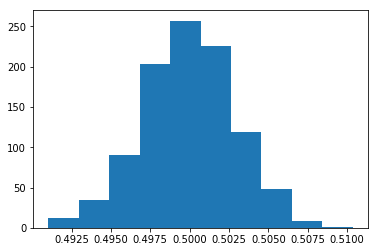

In [6]:
plt.hist(RM)

Finally, __make a plot showing three histograms with `plt.hist()`__: do 1000 trials using `random_means`, but with sample sizes of 500, 2000, and 8000.  (Since the SEM decreases proportional to $\sqrt{n}$, you should see the width of the Gaussian cut in half with each increase in sample size compared to the $n=500$ case.)

(array([ 13.,  43., 119., 202., 258., 206., 108.,  43.,   6.,   2.]),
 array([0.49050125, 0.49259745, 0.49469365, 0.49678985, 0.49888605,
        0.50098225, 0.50307846, 0.50517466, 0.50727086, 0.50936706,
        0.51146326]),
 <a list of 10 Patch objects>)

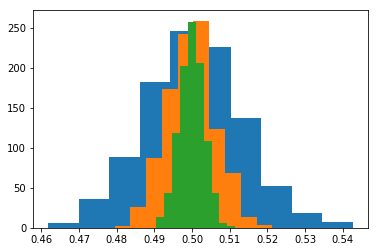

In [7]:
plt.hist(random_means(500,1000))
plt.hist(random_means(2000,1000))
plt.hist(random_means(8000,1000))

## T22.2 - Radioactive decay

If we have a population of particles which undergo radioactive decay, the population over time $N(t)$ will obey the relation

$$
N = N_0 e^{-t/\tau},
$$

where $\tau$ is the lifetime.  This follows from a simple differential equation,
$$
\frac{dN}{dt} = -\frac{N}{\tau}
$$

Actually, this equation has made a hidden assumption: that the number of particles $N$ is so large that writing $dN$ is a sensible thing to do!  The underlying idea has to do with probability: if we observe a _single_ unstable particle for time $dt$, then (from quantum mechanics) the probability we see it decay is

$$
p = 1 - e^{-dt/\tau}.
$$

This is an ideal system to study by Monte Carlo simulation!  Our algorithm will be:

* Start with some population of particles, $N$.
* Take one timestep $dt$, and compute the probability of decay $p$ using $dt$ and $\tau$.
* For each particle, draw a random number $0 < r < 1$.  If $r < p$, then that particle decays.
* Reduce the population $N$ by 1 for each decay that we observe.
* Repeat for the next timestep.

We'll consider the radioactive decay of an isotope of nitrogen, ${}^{16}N$, which has a lifetime of $\tau = 10.286$ s.

First, __implement the function `decay_step(N, tau, dt)`__ below, which should draw $N$ random numbers and follow the algorithm above for a single timestep.  I've provided some comments to guide you.

In [8]:
def decay_step(N, tau, dt):
    # Calculate the decay probability p
    
    # Draw N random numbers between 0 and 1
    
    # Count the number of decays, by counting
    # how many random numbers in the array are less than p
    
    # Return N minus the number of decays
    
    ### BEGIN SOLUTION
    p = 1 - np.exp(-dt/tau)
    
    R = np.random.rand(N)
    
    decay_count = np.count_nonzero(R < p)
    
    return N - decay_count
    ### END SOLUTION

Now run a couple of simple checks:

* First, call `decay_step(100, tau_N17, 0.001)` and verify that no decays are recorded with $dt \ll \tau$.  (This is random, of course, so run a few times - I got 99 on one of my trials just by chance!)
* Then call `decay_step(100, tau_N17, tau_N17)`; on average, we expect 37% of the particles to remain after one lifetime has elapsed.  There will be random variations, but if you run a few times you should see the results are generally close to 37.

In [9]:
tau_N17 = 6.020
tau_N16 = 10.286

### BEGIN SOLUTION
print(decay_step(100, 6.020, 0.001))
print(decay_step(100, 6.020, 6.020))
### END SOLUTION


100
33


### Part B

Next, __implement the function `monte_carlo_decay(N0, tau, t)`__, which takes the initial number of particles `N0`, the lifetime `tau`, and an array `t` of discrete times to track the particles over.  Your function should return an array `N_t` of the same length as `t`, containing the number of particles remaining at each discrete time.

(Hint: you may want to look back at tutorial 17; the way that `monte_carlo_decay()` should work with `decay_step()` is similar to how `euler_solve()` built up the full solution to the ODE on that tutorial using `euler_step()`.)

In [10]:
def monte_carlo_decay(N0, tau, t_array):
    
    # Get dt (step size) and Nt (number of t points) from t_array
    dt, Nt = t_array[1] - t_array[0], len(t_array)
    
    # Initialize array N_t, same length as t_array
    # The "dtype" option is important, because the number
    # of particles should always be an integer!
    N_t = np.zeros_like(t_array, dtype=np.int)
    
    # Set the initial (first) value of N_t to value N0 passed in above
    
    # Iterate, setting N_t[i+1] using the decay_step function and N_t[i]
    
    ### BEGIN SOLUTION
    N_t[0] = N0
    
    for i in range(Nt-1):
        N_t[i+1] = decay_step(N_t[i], tau, dt)
    ### END SOLUTION    
        
    ## Return array N(t)
    return N_t

Now __run the cell below__ to plot your simulation results for an initial population 1000 nitrogen-16 atoms over 60 seconds.  I've also included a plot of the analytic result for $N(t)$ as a red, dashed line.  Hopefully the two curves agree pretty closely!

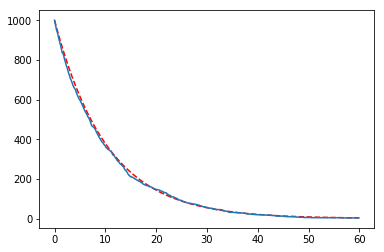

In [11]:
t_decay = np.arange(0, 60, 0.1)
N0 = 1000

N_analytic = N0 * np.exp(-t_decay / tau_N16)
plt.plot(t_decay, N_analytic, linestyle='--', color='r')

N_N16 = monte_carlo_decay(N0, tau_N16, t_decay)
plt.plot(t_decay, N_N16)

Let's run a slightly different test: __run the cell below__ to see simulations for three different choices of `dt`: 0.4, 0.1, and 0.01.  (Hopefully, your results won't depend on the size of `dt` very much either!)

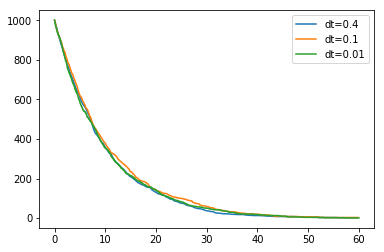

In [12]:
dt_list = (0.4, 0.1, 0.01)

for dt in dt_list:
    t_decay = np.arange(0, 60, dt)
    N_N16 = monte_carlo_decay(N0, tau_N16, t_decay)
    plt.plot(t_decay, N_N16, label='dt={0:g}'.format(dt))

plt.legend()

Of course, as we mentioned the analytic solution assumed that the number of particles is large enough that we can just treat it as a differential equation!  __Copy the first plotting cell above__, change `N0` to 5, and then run it again to show your simulation and the analytic formula.  Which of the two models do you think is a more realistic description of the system starting with 5 particles?

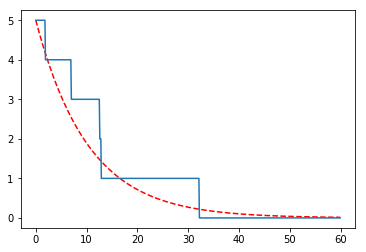

In [22]:
t_decay = np.arange(0, 60, 0.1)

N_analytic = 5 * np.exp(-t_decay / tau_N16)
plt.plot(t_decay, N_analytic, linestyle='--', color='r')


N_N16 = monte_carlo_decay(5, tau_N16, t_decay)

plt.plot(t_decay, N_N16)

# The discrete description is more realistic, since we really only have 5
# particles, so N can't be fractional like the smooth analytic curve predicts!

### Part C _(optional challenge)_

Similar to what we did with the central limit theorem above, we can ask a different sort of statistical question about repeated trials.  Suppose we do many trials starting with 5 atoms of ${}^{16}N$, in which we wait for exactly 10 seconds and measure the number of remaining atoms.  _What does the distribution of $N$ look like?_

To answer this question, __implement the function `measure_after_time(N0, t_meas, tau, trials)` below__, which should use `monte_carlo_decay` from above, loop over it `trials` times, and return an array containing the number of particles remaining after 10 seconds in each trial.

In [23]:
def measure_after_time(N0, t_meas, tau, trials=100):
        
    N_remain = np.zeros(trials, dtype=np.int)

    # Set up a t_array linspace with 200 points for t, running from 0 to t_meas
    
    # Use a for loop to call monte_carlo_decay [trials] times,
    # to find how many particles are remaining after t_meas.
    # Save the results in the array N_remain.
        
    ### BEGIN SOLUTION
    t_array = np.linspace(0, t_meas, 200)
    
    for i in range(trials):
        N_remain[i] = monte_carlo_decay(N0, tau, t_array)[-1]
    ### END SOLUTION
    

    
    return N_remain
    


Now __run the cell below__ for 5 initial atoms, waiting for 10 seconds.  I've started with 200 trials, you can try to increase and see how things change.  (__Warning:__ this is kind of slow, so you may be waiting a while if you try more than a few thousand trials!)

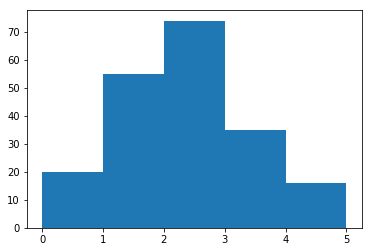

In [24]:
N16 = measure_after_time(5, 10, tau_N16, trials=200)
plt.hist(N16, bins=np.arange(0,6));

This is definitely _not_ a Gaussian distribution - and it won't be, no matter how much we increase the number of trials!  The central limit theorem relies on the random numbers being _continuous_, but here we have a discrete set of possibilities since the number of particles remaining must be an integer.  The lopsided distribution we end up with as a result is known as the __Poisson distribution__.

To prove to yourself that this is an artifact of having integer numbers of particles, __run the cell below which starts with 1000 particles instead of 5__.  You should get something that (although noisy) looks much closer to a Gaussian!

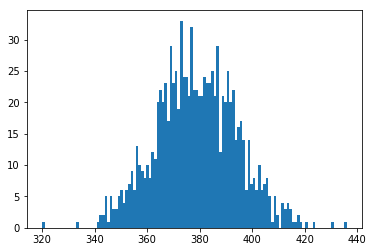

In [26]:
N16 = measure_after_time(1000, 10, tau_N16, trials=1000)
plt.hist(N16, bins=(np.max(N16) - np.min(N16)+1));